<a href="https://colab.research.google.com/github/txusser/Master_IA_Sanidad/blob/main/NN_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Programando una red neuronal desde cero

En este ejemplo veremos como programar una red neuronal desde 0. Empezaremos con el problema que nos encontramos anteriormente que no podía resolver nuestro perceptrón, la clasificación del dataset de MNIST

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np
import time

# Utilizamos la función load_digits para descargarnos los datos de mnist
digits = load_digits()


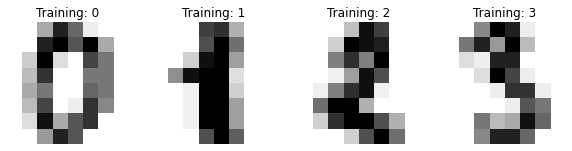

In [104]:
#Vamos a echar un ojo a lo que nos hemos descargado
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

In [107]:
#Preparemos nuestro set de entrenamiento
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
# Imprimimos el tamaño de data.shape para sabe el número de pixeles que tenemos en cada muestra
print(data.shape)
# Dividimos en training y test datasets
X_train, X_test, y_train, y_test = train_test_split(data, digits.target, test_size=0.5, shuffle=False)

(1797, 64)


## Red neuronal de 4 capas en numpy

In [109]:
class DeepNeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.03):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        # Ahora tenemos más parámetros, así que los organizamos en un diccionario
        self.params = self.initialization()

    def initialization(self):
        # Número de neuronas por capa (argumento de entrada)
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def sigmoid(self, x, derivative=False):
      # Función de activación sigmoide
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x, derivative=False):
        # Función de activación softmax
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def forward_pass(self, x_train):
        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.sigmoid(params['Z1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.sigmoid(params['Z2'])

        # hidden layer 2 to output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train, output):
        '''
            Algoritmo de backpropagation
            
        '''
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.sigmoid(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.softmax(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w):
        '''
            Actualización de los parámetros de la red

            θ = θ - η * ∇J(x, y), 
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        '''
        
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        '''
            Esta función hace un forward pass con los datos de validación
            y comprueba que las etiquetas sean correctas.
        '''
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))
        
        return np.mean(predictions)

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            for x,y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)
            
            accuracy = self.compute_accuracy(x_val, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy * 100
            ))

### Results


In [121]:
dnn = DeepNeuralNetwork(sizes=[64, 128, 32, 10],epochs=100, l_rate=0.01)
dnn.train(X_train, y_train, X_test, y_train)

Epoch: 1, Time Spent: 0.17s, Accuracy: 13.70%
Epoch: 2, Time Spent: 0.34s, Accuracy: 16.70%
Epoch: 3, Time Spent: 0.50s, Accuracy: 20.82%
Epoch: 4, Time Spent: 0.68s, Accuracy: 23.61%
Epoch: 5, Time Spent: 0.85s, Accuracy: 26.17%
Epoch: 6, Time Spent: 1.02s, Accuracy: 28.95%
Epoch: 7, Time Spent: 1.19s, Accuracy: 32.63%
Epoch: 8, Time Spent: 1.36s, Accuracy: 35.41%
Epoch: 9, Time Spent: 1.53s, Accuracy: 37.08%
Epoch: 10, Time Spent: 1.70s, Accuracy: 38.98%
Epoch: 11, Time Spent: 1.87s, Accuracy: 39.87%
Epoch: 12, Time Spent: 2.04s, Accuracy: 40.65%
Epoch: 13, Time Spent: 2.22s, Accuracy: 42.09%
Epoch: 14, Time Spent: 2.39s, Accuracy: 42.76%
Epoch: 15, Time Spent: 2.56s, Accuracy: 42.87%
Epoch: 16, Time Spent: 2.73s, Accuracy: 43.43%
Epoch: 17, Time Spent: 2.90s, Accuracy: 43.99%
Epoch: 18, Time Spent: 3.07s, Accuracy: 44.43%
Epoch: 19, Time Spent: 3.25s, Accuracy: 44.99%
Epoch: 20, Time Spent: 3.41s, Accuracy: 45.43%
Epoch: 21, Time Spent: 3.59s, Accuracy: 45.77%
Epoch: 22, Time Spent: